## AGUATHON ITA

#### Resumen 5

Estudio sobre la influencia en R2 de columnas adicionales de rios desfasadas en tiempo diferentes deltas. En este script se simplifica el codigo para automatizar la generacion de resultados. No se trata de un script final optimizado, sino simplificado para analizar la influencia de cada variable.

Se usa la funcion df.shift(period = delat) para desfasar la serie temporal de cada rio. Se prueban diferentes deltas de desfase para determinar cual de ellos provoca el mayor incremento de R2.

In [1]:
import os
import scipy
import numpy as np
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import datetime as dt

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

## Fun

In [2]:
def load_rios():
    ''' 
    Load CSV using Pandas saved in current working directory
    '''
    cwd = os.getcwd()
    in_path = os.path.join(cwd,'data','ENTRADA')
    in_file = 'datos.csv'
    filename  = os.path.join(in_path,in_file)
    data = pd.read_csv(filename, parse_dates = ['time'], index_col = 'time') #, names=names)
    return data

def load_meteo(csvfile, cols):
    ''' 
    Load CSV using Pandas saved in current working directory
    '''
    cwd = os.getcwd()
    in_path = os.path.join(cwd, 'data', 'DatosPorEstacion')
    in_file = csvfile + '.csv'
    filename  = os.path.join(in_path,in_file)
    data = pd.read_csv(filename,sep=";", usecols = cols,
                       parse_dates = ['FECHA'], index_col='FECHA')
    return data


def column_shift(df, dup_cols, N, delta ): 
    '''
    Deriving new features by shifting columns by a given timedelta. That is, each time series 
    is shifted back N*delta, N*2*delta, N*3*delta, where N is number of columns and delta
    time shift periods.
    '''    
    dfs = df.copy()
    for col in dup_cols:
        for i in range (1,N+1):
            colname = col + "_" + str(i*delta)
            dfs[colname] = dfs[col].shift(periods = i*delta)
    return dfs 


In [38]:
############################################################## 
##     DATA LOADING
##############################################################

### RIOS
df_rios = load_rios()
df_rios.columns = ['Ala','Gri','Nov','Tau','Tud','Zar','Risk','P24','P48','P72']
start = df_rios.index[0]
end = df_rios.index[-1]

### Estaciones
estaciones = {'pa1':'9262-19530901-20190131',   # pna
              'pa2':'9263D-19750101-20190302',  # pna Aerop
              'za1':'9434-19410101-20190302',   # zar Aerop
              'za2':'9244X-19920204-20190302',  # zar Sos rey 
              'hu1':'9208E-20060201-20190302',  # huesca aragues
              'hu2':'9201K-19920101-20190302',  # huesca jaca
              'log':'9170-19481101-20190302',   # Logroño
              'cal':'9394X-19930401-20190302',  # Calatayud
             }

locations = ['pa1', 'pa2', 'za1', 'za2', 'log', 'cal', 'hu1', 'hu2']

### TEMP
cols = ['FECHA','TMEDIA']
dframes = []
for k,v in estaciones.items():
    if k in locations:
        df = load_meteo(v, cols)
        df = df.resample('H').ffill()
        df = df[start:end]
        df.columns = ['Tm_'+k]
        dframes.append(df)
df_temp = pd.concat(dframes, axis=1)


locations = ['pa1', 'pa2', 'hu1', 'hu2', 'log'] # mejores para lluvia

### RAIN
cols = ['FECHA','PRECIPITACION']
dframes = []
for k,v in estaciones.items():
    if k in locations:    
        df = load_meteo(v, cols)
        df = df.resample('H').ffill()
        df = df[start:end]
        df.columns = ['rain_'+ k] 
        dframes.append(df)
df_rain = pd.concat(dframes, axis=1)


locations = ['pa2', 'za1', 'log'] # solo estas tienen datos de presion
    
### PRESION
cols = ['FECHA','PRESMAX', 'PRESMIN']
dframes = []
for k,v in estaciones.items():
    # load selected locations only 
    if k in locations:
        #  Read csv into a DataFrame: df
        df = load_meteo(v, cols)
        df = df.resample('H').ffill()
        df = df[start:end]        
        df.columns = ['Pmax_'+ k, 'Pmin_'+ k] 
        dframes.append(df)
df_pres = pd.concat(dframes, axis=1)



####################################################################### 
######     DATA PREPARATION
######################################################################


#### RAIN DATA
df_rain.fillna(value = 0,inplace=True) 
# replace string values defined by AEMET
df_rain.replace(to_replace =['Ip','Acum','Varias'] , value =0 , inplace = True)
#convert Text columns to numeric
for col in df_rain.columns:
    df_rain[col] = pd.to_numeric(df_rain[col], errors='coerce')


#### TEMP DATA
df_temp.fillna(method = 'ffill',inplace=True) 
df_temp.fillna(method = 'bfill',inplace=True)

#### PRES DATA
df_pres.fillna(method = 'ffill',inplace=True) 
df_pres.fillna(method = 'bfill',inplace=True)

### SELECT RIOS DATA
target = 'P72'
# selected features
cols = ['Ala','Tud','Nov','Zar']#,'Gri']
cols.append(target)
df_rios = df_rios[cols]

### RIOS + LLUVIA + PRES (TEMP eliminada porque no ayuda)
#df = pd.concat([df_rios, df_rain, df_pres], axis=1)
#df = df_rios
df = pd.concat([df_rios, df_rain], axis=1)


dup = 1     # time shift columns? 
N = 1       # number of derived columns per feature
delta = 1   # time delta in hr
dup_cols = ['Tud']#, 'Tud', 'Zar']


rows = []
for N in range(1,N+1):
    for delta in range(1,delta+1):
        if dup:
            dfs = column_shift(df, dup_cols, N, delta)
        else:
            dfs = df.copy()
            
        dfs.dropna(axis=0, how='any', inplace=True)

        ############################################################### 
        ########       ML SPLIT AND REGRESSION
        ###############################################################


        features = [x for x in dfs.columns if x != target]
        Y = dfs[target]
        X = dfs.loc[:,features]


        kfold = KFold(n_splits=10, random_state=0)
        model = LinearRegression()
        scoring = 'r2'
        results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
        mn = results.mean()*100.0
        sd = results.std()*100.0
        #print("N:{}, dt:{}, Accuracy: {:.3f}% ({:.3f}%)".format(N, delta, mn, sd))
            
        row = {'N':N, 'delta':delta, 'mn':mn, 'sd':sd}     
        rows.append(row)
        
dfres = pd.DataFrame(rows)
dfres

,N,delta,mn,sd
0,1,1,81.727495,9.31665


In [27]:
idx = dfres['mn'].idxmax()
dfres.iloc[idx]

N          1.000000
delta    145.000000
mn        81.952306
sd         8.353099
Name: 144, dtype: float64

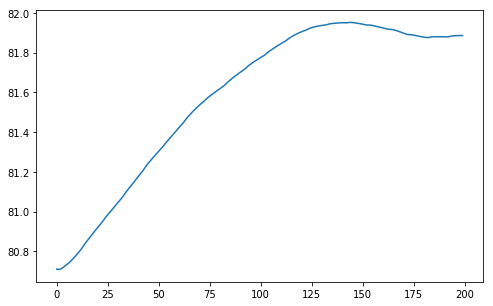

In [28]:
# Zaragoza, Max @ -145 hrs
fig, (ax1) = plt.subplots(1, 1, sharex=True, 
                                sharey=False,
                                figsize=(8,5))
dfres['mn'].plot( ax=ax1);

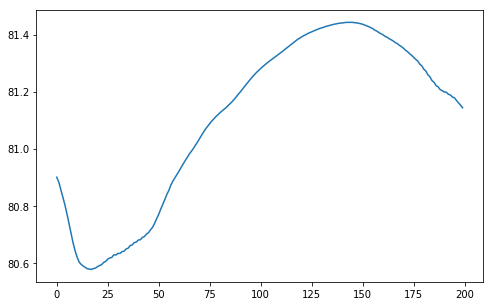

In [19]:
# Alagon, Max @ -144hrs
fig, (ax1) = plt.subplots(1, 1, sharex=True, 
                                sharey=False,
                                figsize=(8,5))
dfres['mn'].plot( ax=ax1);

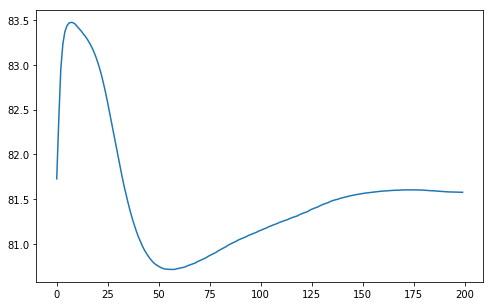

In [16]:
# Tudela, Max @ -7hrs
fig, (ax1) = plt.subplots(1, 1, sharex=True, 
                                sharey=False,
                                figsize=(8,5))
dfres['mn'].plot( ax=ax1);

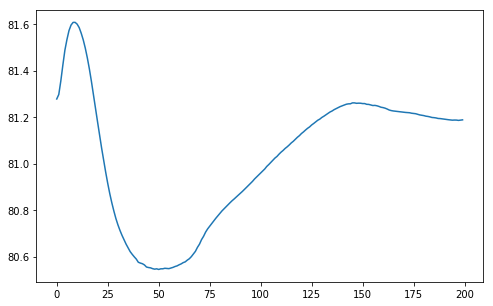

In [25]:
# NOVILLAS, Max @ -9hrs
fig, (ax1) = plt.subplots(1, 1, sharex=True, 
                                sharey=False,
                                figsize=(8,5))
dfres['mn'].plot( ax=ax1);

### Estudio Sensibilidad Variables
```
Rios
* 71.393% (14.716%) Ala,Tud,Nov,Zar    <= (1)

Rios + Lluvia por estacion

* 80.744% (9.111%)  (1) + pa1 + pa2 + hu1 + hu2 + log

Duplicado de columna:

* Ala, h = 144, Max = 81.443% (8.385%)
* Tud, h =   8, Max = 83.475% (8.052%)
* Nov, h =  10, MAx = 81.608% (8.508%)
* Zar, h = 145, MAx = 81.952% (8.353%)
*
```

In [ ]:
### PLot de correlacion entre features
colormap = plt.cm.RdBu
plt.figure(figsize=(40,40))
plt.title(u'10 hours', y=1.05, size=16)

mask = np.zeros_like(dfs.corr())
mask[np.triu_indices_from(mask)] = True

svm = sns.heatmap(dfs.corr(), mask=mask, linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)       
            

